# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

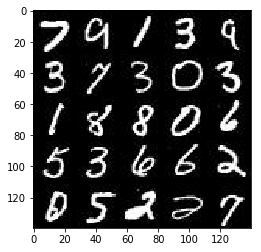

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

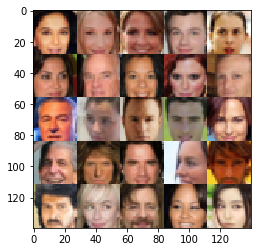

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
    
        # 14 x 14 x 64
        x_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu_1 = tf.maximum(alpha * x_1, x_1)
        
        # 14 x 14 x 128
        x_2 = tf.layers.conv2d(relu_1, 128, 5, strides=1, padding='same')
        bn_2 = tf.layers.batch_normalization(x_2, training=True)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        
        # 7 x 7 x 256
        x_3 = tf.layers.conv2d(relu_2, 256, 5, strides=2, padding='same')
        bn_3 = tf.layers.batch_normalization(x_3, training=True)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)

        flattened = tf.reshape(relu_3, (-1, 7*7*256))
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        x_1 = tf.layers.dense(z, 7*7*256)
        
        # 7 x 7 x 256
        x_1 = tf.reshape(x_1, (-1, 7, 7, 256))
        x_1 = tf.layers.batch_normalization(x_1, training=is_train)
        x_1 = tf.maximum(alpha * x_1, x_1)
        
        # 7 x 7 x 128
        x_2 = tf.layers.conv2d_transpose(x_1, 128, 5, strides=1, padding='same')
        x_2 = tf.layers.batch_normalization(x_2, training=is_train)
        x_2 = tf.maximum(alpha * x_2, x_2)
        
        # 14 x 14 x 64
        x_3 = tf.layers.conv2d_transpose(x_2, 64, 5, strides=2, padding='same')
        x_3 = tf.layers.batch_normalization(x_3, training=is_train)
        x_3 = tf.maximum(alpha * x_3, x_3)
        
        # 28 x 28 x 3
        logits = tf.layers.conv2d_transpose(x_3, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 7.1338
Epoch 1/2... Discriminator Loss: 4.1197... Generator Loss: 0.0312
Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 2.4510
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 1.6981... Generator Loss: 0.5116
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 2.1701
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.6682


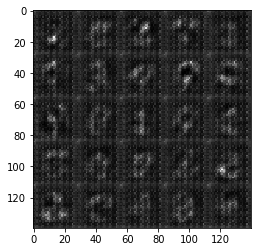

Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.4598
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.5606
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.6729
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 1.1787
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 2.2323


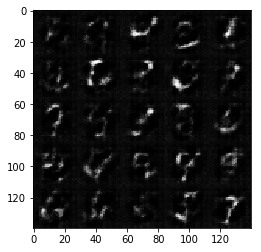

Epoch 1/2... Discriminator Loss: 1.6560... Generator Loss: 0.4023
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 1.6227
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 3.1667
Epoch 1/2... Discriminator Loss: 0.9464... Generator Loss: 2.5443
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.8315... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 1.2913
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 0.6603
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 2.1933
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.5780


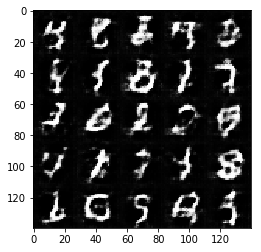

Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.4459
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.7879
Epoch 1/2... Discriminator Loss: 1.3009... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 2.7556
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.4746... Generator Loss: 0.4490


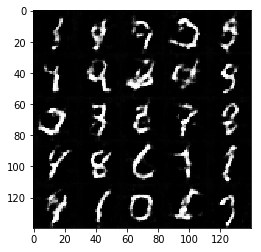

Epoch 1/2... Discriminator Loss: 2.3488... Generator Loss: 0.2101
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.0285
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 1.3762
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 0.8232
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 1.2955
Epoch 1/2... Discriminator Loss: 7.8795... Generator Loss: 9.4508
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.1758
Epoch 1/2... Discriminator Loss: 1.9951... Generator Loss: 3.3700


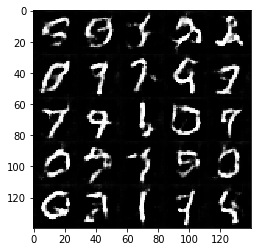

Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.4048
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 1.6109
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 2.5182... Generator Loss: 0.1889
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 1.2011


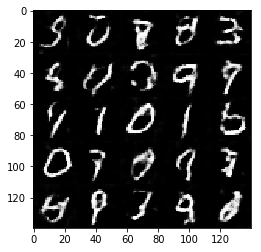

Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.3414
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.9515
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.0652
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 1.2347
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.3288


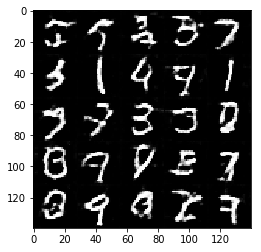

Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.1856
Epoch 1/2... Discriminator Loss: 0.9361... Generator Loss: 1.5621
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 2.1462
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 2.3324
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.1686
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5243


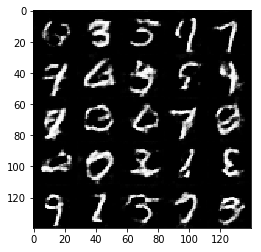

Epoch 1/2... Discriminator Loss: 1.6004... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 1.5384
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.2718
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 1.5645
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 1.2360
Epoch 1/2... Discriminator Loss: 0.9581... Generator Loss: 1.0957
Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 1.0107


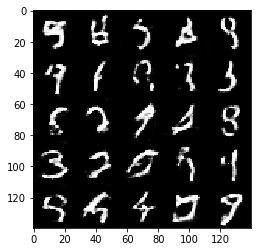

Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 1.0461
Epoch 1/2... Discriminator Loss: 1.4100... Generator Loss: 0.8958
Epoch 1/2... Discriminator Loss: 1.7504... Generator Loss: 0.3645
Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 1.9320
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 2.0510
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.4118
Epoch 2/2... Discriminator Loss: 1.1290... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 2.7440... Generator Loss: 3.4045
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 1.5261


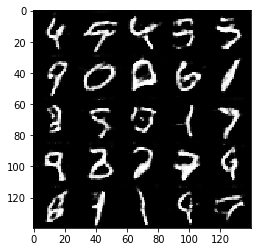

Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.4436
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.7867
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 1.9867... Generator Loss: 0.2971
Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 1.9081
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.0142
Epoch 2/2... Discriminator Loss: 0.9192... Generator Loss: 1.3346
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 2.3556... Generator Loss: 0.2023
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.3719


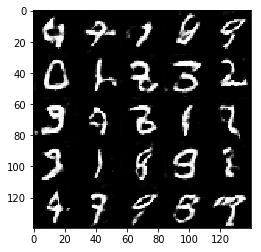

Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 1.4293
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.1961
Epoch 2/2... Discriminator Loss: 1.5396... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.9728
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 2.2578
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 0.9889
Epoch 2/2... Discriminator Loss: 1.5633... Generator Loss: 3.0324
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 1.1883


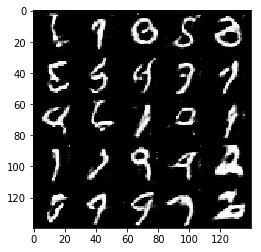

Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.6728
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.2434
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 2.2711
Epoch 2/2... Discriminator Loss: 0.7977... Generator Loss: 1.5740
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.2726
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 2.3950


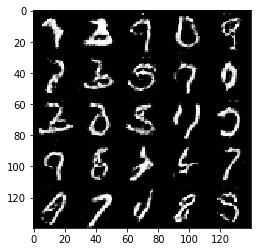

Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 0.6934... Generator Loss: 1.7334
Epoch 2/2... Discriminator Loss: 1.5822... Generator Loss: 0.4866
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 2.5447
Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 1.2433
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.9416
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.7412
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.9541


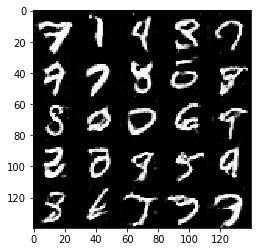

Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 1.6007
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.1140... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 2.1404
Epoch 2/2... Discriminator Loss: 0.6504... Generator Loss: 1.6515
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 2.2793
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 2.0832
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 1.5980
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 2.9043


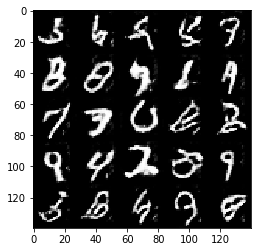

Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.4784... Generator Loss: 0.5125
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 2.9497... Generator Loss: 0.1614
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.9104
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 1.4242
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 2.3675


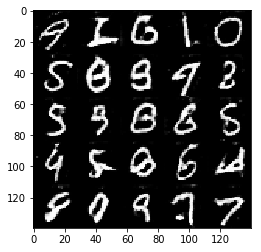

Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.3292
Epoch 2/2... Discriminator Loss: 2.2523... Generator Loss: 0.2327
Epoch 2/2... Discriminator Loss: 0.6801... Generator Loss: 1.6915
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 2.5455
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 1.6668
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.5640
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.6672
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.2258


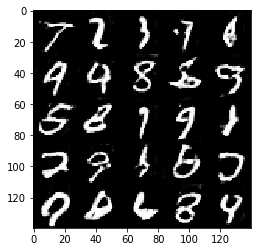

Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.5617
Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.7103
Epoch 2/2... Discriminator Loss: 1.5287... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.6079
Epoch 2/2... Discriminator Loss: 2.5725... Generator Loss: 0.2354
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.7963
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.8143... Generator Loss: 1.6920
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.6439
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.2225


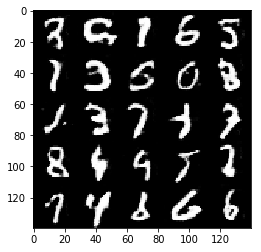

Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: 0.9737
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.6028
Epoch 2/2... Discriminator Loss: 1.0361... Generator Loss: 2.6899
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.8542
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.4138
Epoch 2/2... Discriminator Loss: 1.7065... Generator Loss: 0.4903
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.3984


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 5.1625
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 3.8277... Generator Loss: 17.9560
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 2.2253
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 3.1396
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 5.3353
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 2.9147


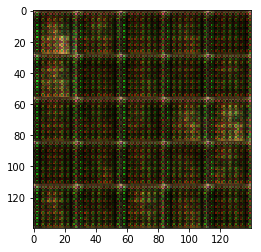

Epoch 1/1... Discriminator Loss: 0.6034... Generator Loss: 1.8606
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 2.3245
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 2.0513
Epoch 1/1... Discriminator Loss: 1.9830... Generator Loss: 7.4779
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.6018
Epoch 1/1... Discriminator Loss: 2.4310... Generator Loss: 6.9028
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 3.4711
Epoch 1/1... Discriminator Loss: 2.3032... Generator Loss: 0.1943


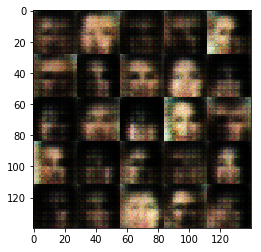

Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 2.1006
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 2.5574
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.5526


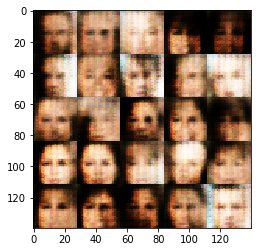

Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 2.1911
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 2.6981
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.4758
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 2.8271
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.9321


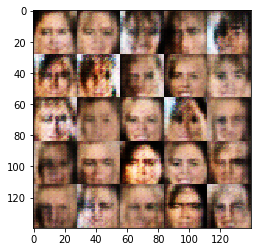

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 2.2500
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.3877
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.6280... Generator Loss: 3.4603
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 2.1647
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 2.7413
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.2778


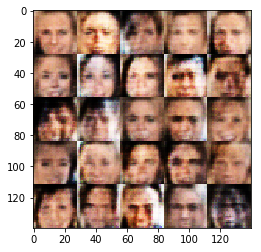

Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.9492... Generator Loss: 0.2946
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 2.9756
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.2332


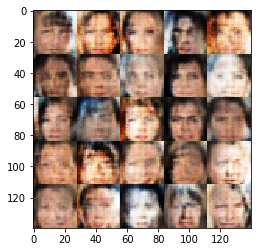

Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.7321... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 2.0587... Generator Loss: 0.2722
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.1928


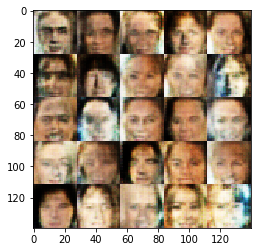

Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.2574
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.6020


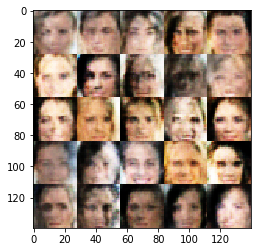

Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.5428


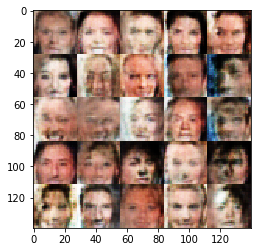

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.7779... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.5982
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.5538
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 1.0767


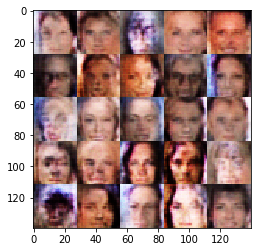

Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.4410
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0163


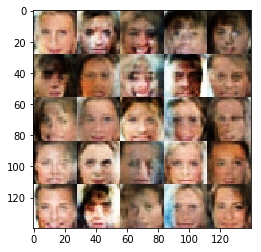

Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.5873
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.8077... Generator Loss: 0.3224
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.1455


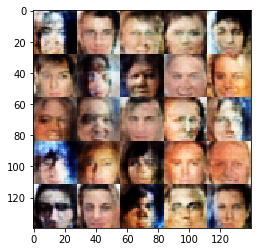

Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.2024
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.8710


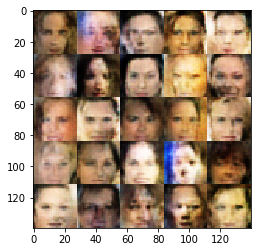

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.8014
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.8004
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.2965


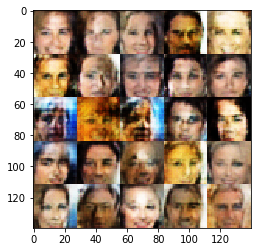

Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 2.2327
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 2.6168
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6050


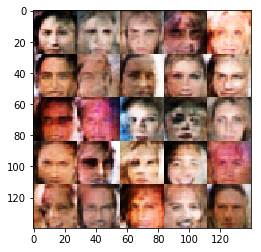

Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.4732
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.4884
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.7081
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.3378


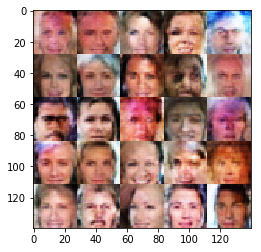

Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.7076
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.6169
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.3202
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.6937... Generator Loss: 0.3602
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6435


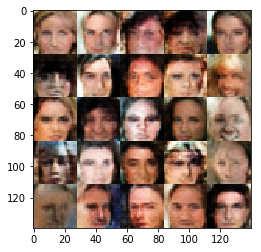

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.7245
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.2279
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.0446


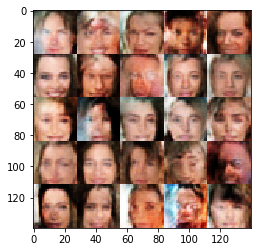

Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 2.2287
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.8640


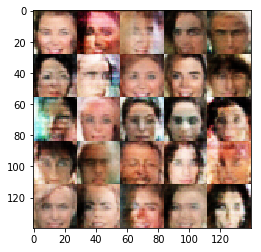

Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.5543
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6976


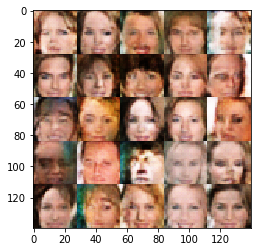

Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.4441
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.5147
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.8678


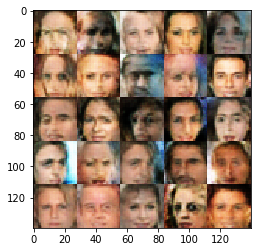

Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 2.1397
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.7070


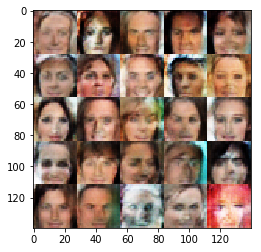

Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.6344
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 1.2213
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.4713


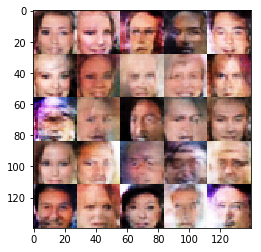

Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.6339
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6628


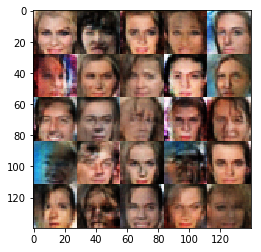

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.6669


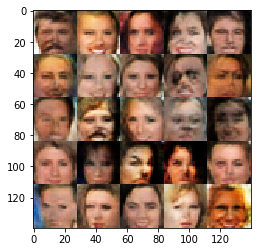

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.6536
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.6641
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6034


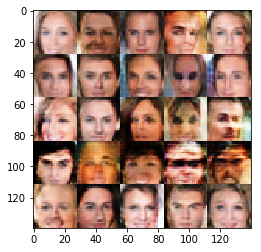

Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 2.4506
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.2198


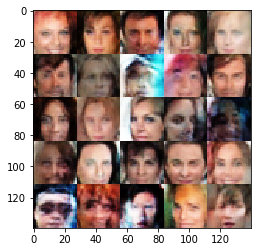

Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.8275
Epoch 1/1... Discriminator Loss: 1.7670... Generator Loss: 0.3487
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.6222
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 2.7307


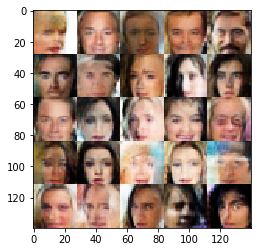

Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 2.5365
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.9524
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.2088


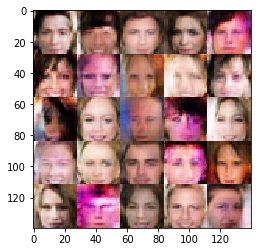

Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 1.9617... Generator Loss: 0.2826
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.7430
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 2.7022


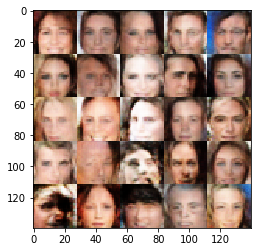

Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.5429


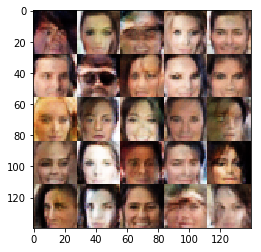

Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.5546


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.